In [111]:
import jax
import chex
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

In [66]:
%config InlineBackend.figure_format = "retina"

In [13]:
def log_partition(eta):
    eta1, eta2 = eta
    
    log_A = - eta1 ** 2 / (4 * eta2) - jnp.log(-2 * eta2) / 2 - 1 / 2 * jnp.log(2 * eta2)
    return log_A

In [14]:
eta0 = jnp.array([1, 3.0])

In [18]:
jax.grad(log_partition)(eta0)

Array([-0.16666667, -0.30555555], dtype=float32)

In [19]:
jax.jacfwd(jax.grad(log_partition))(eta0)

Array([[-0.16666667,  0.05555556],
       [ 0.05555556,  0.0925926 ]], dtype=float32)

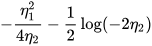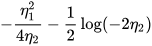

## Bernoulli

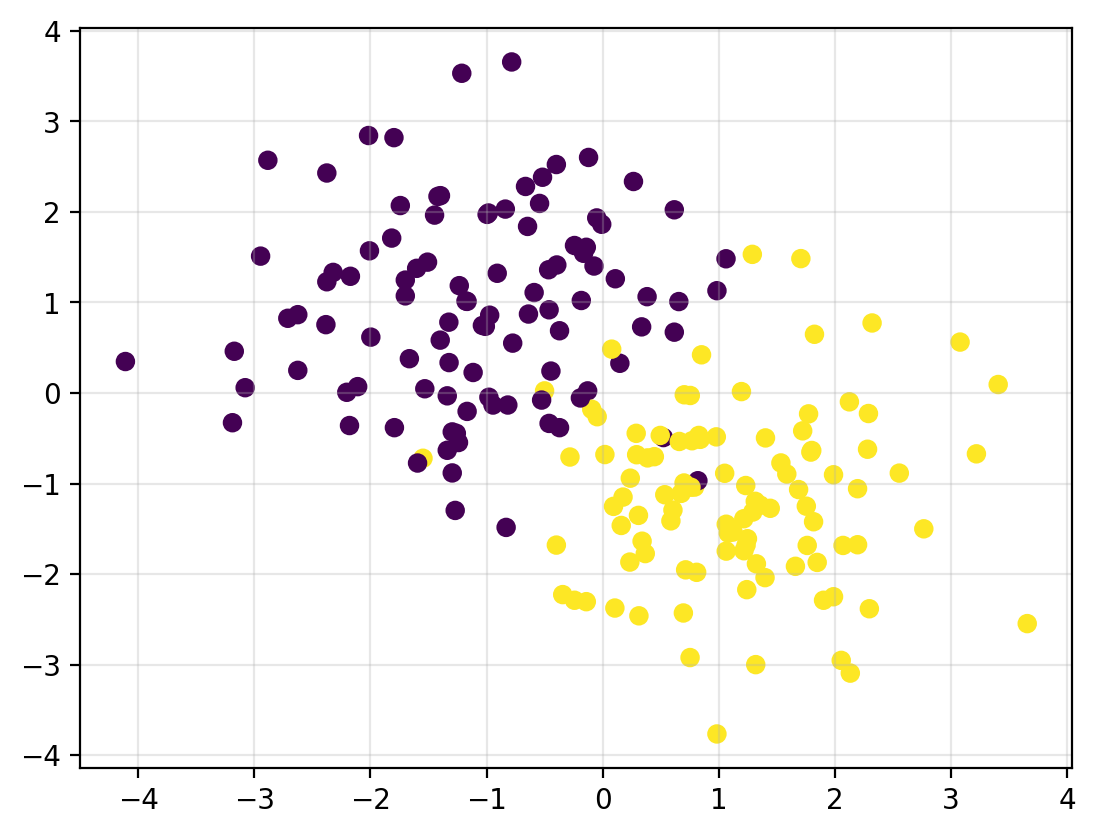

In [101]:
key = jax.random.PRNGKey(314)
key_train, key_data = jax.random.split(key)
key_1, key_0, key_shuffle = jax.random.split(key_data, 3)

n_samp_per_class = 100
mu0 = jnp.array([1, -1])
mu1 = jnp.array([-1, 1])

new_ixs = jax.random.choice(key_shuffle, n_samp_per_class * 2, replace=False, shape=(n_samp_per_class * 2,))
X0 = jax.random.multivariate_normal(key_0, mu0, cov=jnp.eye(2), shape=(n_samp_per_class,))
X1 = jax.random.multivariate_normal(key_1, mu1, cov=jnp.eye(2), shape=(n_samp_per_class,))


X = jnp.r_[X0, X1]
y = jnp.arange(n_samp_per_class * 2) < n_samp_per_class

X = X[new_ixs]
y = y[new_ixs]

plt.scatter(*X.T, c=y)
plt.grid(alpha=0.3)

In [137]:
from jax.flatten_util import ravel_pytree

In [112]:
@chex.dataclass
class Bel:
    mean: chex.Array
    cov: chex.Array

In [173]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        # x = nn.Dense(10)(x)
        x = nn.Dense(1)(x)
        return x # Eta
    
model = MLP()
params = model.init(key_train, X)
params, rfn = ravel_pytree(params)
nparams = len(params)

def applyfn(params, x):
    return model.apply(rfn(params), x)

In [164]:
eta = - 0.13
p = 1 / (1 + jnp.exp(-eta))
p

Array(0.46754542, dtype=float32, weak_type=True)

In [165]:
p * (1 - p)

Array(0.24894671, dtype=float32, weak_type=True)

In [246]:
@jax.jit
def log_partition(eta):
    return jnp.log(1 + jnp.exp(eta))

@jax.jit
def mean(eta):
    return jax.jacfwd(log_partition)(eta)

@jax.jit
def covariance(eta):
    return jax.hessian(log_partition)(eta).squeeze()

@jax.jit
def linkfn(params, x):
    eta = applyfn(params, x)
    return eta

In [254]:
bel_init = Bel(
    mean=params,
    cov=jnp.eye(nparams) * 1e-5
)

In [273]:
dynamics_covariance = 0.0 # TODO: Change

dmodel = jax.jacfwd(applyfn)

def step(bel, xs):
    xt, yt = xs
    pcov_pred = bel.cov + dynamics_covariance
    pmean_pred = bel.mean
    nparams = len(pmean_pred)
    I = jnp.eye(nparams)
    
    eta = linkfn(bel.mean, xt).astype(float)
    yhat = mean(eta)
    err = yt - yhat
    Rt = covariance(eta)
    
    Ht = dmodel(pmean_pred, xt)
    Kt = pcov_pred @ Ht.T @ jnp.linalg.inv(Ht @ pcov_pred @ Ht.T + Rt)
    
    pcov = (I - Kt @ Ht) @ pcov_pred
    pmean = pmean_pred + (Kt @ err).squeeze()
    
    import pdb; pdb.set_trace()
    bel = bel.replace(mean=pmean, cov=pcov)
    return bel, bel

In [274]:
D = (X, y)
bel, _ = jax.lax.scan(step, bel_init, D)

> /tmp/ipykernel_3633297/2978704487.py(24)step()
     21     pmean = pmean_pred + (Kt @ err).squeeze()
     22 
     23     import pdb; pdb.set_trace()
---> 24     bel = bel.replace(mean=pmean, cov=pcov)
     25     return bel, bel



ipdb>  c


In [284]:
eta = linkfn(bel.mean, X)
yhat = jax.nn.sigmoid(eta) > 0.5

In [290]:
(y == yhat.squeeze()).mean()

Array(0.76, dtype=float32)

In [292]:
XX = jnp.mgrid[-4:4:0.1, -4:4:0.1]
XX.shape

(2, 80, 80)

In [305]:
X.shape

(200, 2)

In [306]:
XX.shape

(2, 80, 80)

In [310]:
jax.vmap(applyfn, (None, 1))(bel.mean, XX)

ScopeParamShapeError: Initializer expected to generate shape (2, 1) but got shape (80, 1) instead for parameter "kernel" in "/Dense_0". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

In [301]:
XX.reshape(-1, 2).shape

(6400, 2)